In [6]:
import argparse
import time
import os
from random import sample
import numpy as np

from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem import QED
from rdkit.Chem import AllChem
from rdkit import DataStructs

from scaffold_constrained_model import scaffold_constrained_RNN
from train_agent import train_agent
from data_structs import Vocabulary, Experience
from scoring_functions import get_scoring_function
from utils import Variable, seq_to_smiles, fraction_valid_smiles, unique
from rdkit.Chem.Draw import IPythonConsole

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import torch

import warnings
warnings.filterwarnings('ignore')

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

%matplotlib inline 
# Loading trained model and appropriate vocabulary

run_experiments = False

voc = Vocabulary(init_from_file="data/DistributionLearningBenchmark/Voc")
    
Agent = scaffold_constrained_RNN(voc)
print(Agent.rnn.state_dict)
if torch.cuda.is_available():
    Agent.rnn.load_state_dict(torch.load('data/DistributionLearningBenchmark/Prior_ChEMBL_randomized.ckpt'))
else:
    Agent.rnn.load_state_dict(torch.load('data/DistributionLearningBenchmark/Prior_ChEMBL_randomized.ckpt', map_location=lambda storage, loc: storage))


<bound method Module.state_dict of MultiGRU(
  (embedding): Embedding(50, 128)
  (gru_1): GRUCell(128, 512)
  (gru_2): GRUCell(512, 512)
  (gru_3): GRUCell(512, 512)
  (linear): Linear(in_features=512, out_features=50, bias=True)
)>


# 1. Distribution learning benchmarks

# Generating results

In [2]:
#
# calculation of synthetic accessibility score as described in:
#
# Estimation of Synthetic Accessibility Score of Drug-like Molecules based on Molecular Complexity and Fragment Contributions
# Peter Ertl and Ansgar Schuffenhauer
# Journal of Cheminformatics 1:8 (2009)
# http://www.jcheminf.com/content/1/1/8
#
# several small modifications to the original paper are included
# particularly slightly different formula for marocyclic penalty
# and taking into account also molecule symmetry (fingerprint density)
#
# for a set of 10k diverse molecules the agreement between the original method
# as implemented in PipelinePilot and this implementation is r2 = 0.97
#
# peter ertl & greg landrum, september 2013
#


from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import pickle

import math
from collections import defaultdict

import os.path as op

_fscores = None


def readFragmentScores(name='fpscores'):
    import gzip
    global _fscores
    # generate the full path filename:

    data = pickle.load(gzip.open('fpscores.pkl.gz'))
    outDict = {}
    for i in data:
        for j in range(1, len(i)):
            outDict[i[j]] = float(i[0])
    _fscores = outDict


def numBridgeheadsAndSpiro(mol, ri=None):
    nSpiro = rdMolDescriptors.CalcNumSpiroAtoms(mol)
    nBridgehead = rdMolDescriptors.CalcNumBridgeheadAtoms(mol)
    return nBridgehead, nSpiro


def calculateScore(m):
    if _fscores is None:
        readFragmentScores()

    # fragment score
    fp = rdMolDescriptors.GetMorganFingerprint(m,
                                               2)  # <- 2 is the *radius* of the circular fingerprint
    fps = fp.GetNonzeroElements()
    score1 = 0.
    nf = 0
    for bitId, v in fps.items():
        nf += v
        sfp = bitId
        score1 += _fscores.get(sfp, -4) * v
    score1 /= nf

    # features score
    nAtoms = m.GetNumAtoms()
    nChiralCenters = len(Chem.FindMolChiralCenters(m, includeUnassigned=True))
    ri = m.GetRingInfo()
    nBridgeheads, nSpiro = numBridgeheadsAndSpiro(m, ri)
    nMacrocycles = 0
    for x in ri.AtomRings():
        if len(x) > 8:
            nMacrocycles += 1

    sizePenalty = nAtoms**1.005 - nAtoms
    stereoPenalty = math.log10(nChiralCenters + 1)
    spiroPenalty = math.log10(nSpiro + 1)
    bridgePenalty = math.log10(nBridgeheads + 1)
    macrocyclePenalty = 0.
    # ---------------------------------------
    # This differs from the paper, which defines:
    #  macrocyclePenalty = math.log10(nMacrocycles+1)
    # This form generates better results when 2 or more macrocycles are present
    if nMacrocycles > 0:
        macrocyclePenalty = math.log10(2)

    score2 = 0. - sizePenalty - stereoPenalty - spiroPenalty - bridgePenalty - macrocyclePenalty

    # correction for the fingerprint density
    # not in the original publication, added in version 1.1
    # to make highly symmetrical molecules easier to synthetise
    score3 = 0.
    if nAtoms > len(fps):
        score3 = math.log(float(nAtoms) / len(fps)) * .5

    sascore = score1 + score2 + score3

    # need to transform "raw" value into scale between 1 and 10
    min = -4.0
    max = 2.5
    sascore = 11. - (sascore - min + 1) / (max - min) * 9.
    # smooth the 10-end
    if sascore > 8.:
        sascore = 8. + math.log(sascore + 1. - 9.)
    if sascore > 10.:
        sascore = 10.0
    elif sascore < 1.:
        sascore = 1.0

    return sascore


def processMols(mols):
    print('smiles\tName\tsa_score')
    for i, m in enumerate(mols):
        if m is None:
            continue

        s = calculateScore(m)

        smiles = Chem.MolToSmiles(m)
        print(smiles + "\t" + m.GetProp('_Name') + "\t%3f" % s)


#
#  Copyright (c) 2013, Novartis Institutes for BioMedical Research Inc.
#  All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are
# met:
#
#     * Redistributions of source code must retain the above copyright
#       notice, this list of conditions and the following disclaimer.
#     * Redistributions in binary form must reproduce the above
#       copyright notice, this list of conditions and the following
#       disclaimer in the documentation and/or other materials provided
#       with the distribution.
#     * Neither the name of Novartis Institutes for BioMedical Research Inc.
#       nor the names of its contributors may be used to endorse or promote
#       products derived from this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS
# "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT
# LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR
# A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT
# OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL,
# SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT
# LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE,
# DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY
# THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
# (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [3]:
def int_diversity(smiles):
    if len(smiles)==0:
        return 0.5
    diversity = 0
    for s in smiles:
        fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 4)
        for m in smiles:
            query_fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(m), 4)
            diversity += DataStructs.TanimotoSimilarity(query_fp, fp) 
    diversity /= len(smiles)**2
    return 1 - diversity

def validity_and_uniqueness_assessement(pattern= "c1c(*)cc2c(c1)c(*)ccn2", refs = None, n_tryouts=5000, save_path=None):
    n_valid = 0
    n_unique = 0
    logP = []
    MW = []
    qed_list = []
    SAS = []
    HD_list = []
    HA_list = []
    smiles = []
        
    seqs, agent_likelihood, entropy = Agent.sample(pattern, batch_size=n_tryouts)
        #seqs, agent_likelihood, entropy = Agent.sample(1)
    for seq in seq_to_smiles(seqs, voc):
        mol = Chem.MolFromSmiles(seq)
    
        if mol:
            n_valid += 1

            if Chem.MolToSmiles(mol) not in smiles:
                smiles.append(Chem.MolToSmiles(mol))
                n_unique += 1
            try:
                SAS.append(calculateScore(mol))
                MW.append(Descriptors.ExactMolWt(mol))
                logP.append(Descriptors.MolLogP(mol))
                qed_list.append(QED.qed(mol))
                HA_list.append(Lipinski.NumHAcceptors(mol))
                HD_list.append(Lipinski.NumHDonors(mol))
            except:
                pass
    
    if save_path:
        
        df_summary = pd.DataFrame(columns = ["Scaffold", "Percentage valid molecules", "Percentage unique molecules"])
        df_summary["Scaffold"] = [pattern]
        df_summary["Percentage valid molecules"] = [n_valid/n_tryouts]
        df_summary["Percentage unique molecules"] = [n_unique/n_valid]

        df_details = pd.DataFrame(columns = ["Molecular weight",
                                    "Calculated log P", "Synthetizability Accessibility Score (SAS)", "Quantitative Estimate of Drug-likeness (QED)",
                                    "Number of H bonds acceptors", "Number of H bonds donors"])
        df_details["Molecular weight"] = MW
        df_details["Calculated log P"] = logP
        df_details["Synthetizability Accessibility Score (SAS)"] = SAS
        df_details["Quantitative Estimate of Drug-likeness (QED)"] = qed_list
        df_details["Number of H bonds acceptors"] = HA_list
        df_details["Number of H bonds donors"] = HD_list
        
        df_details.to_csv(save_path + "_details.csv")
        df_summary.to_csv(save_path + "_summary.csv")
    return n_valid/n_tryouts, n_unique/n_valid, MW, logP, SAS, qed_list, HA_list, HD_list

In [4]:
patterns = ['N(*)2C(=C)N(c3ccc(C#N)c(C(F)(F)F)c3)C(=O)C23CCC3',
 'C(*)N2CCN(C(=O)Oc3cncc(*)c3)C(C)C2',
 'c(*)1ccc(Nc2cnc(N)c(NCc3ccc4ncccc4c3)n2)nc1',
 'N(*)C(=O)C(=O)N2CCC(c3ccnc4ccc(*)cc34)CC2',
 'C(*)c1nc(=O)c(S(=O)(=O)c2ccc(*)c(*)c2)c(O)n1(*)',
 'C(*)c1cnn(CC2C(NC(=O)C(=NOC3(C(*)O)CC3)c3csc(*)n3)C(=O)N2(*))n1',
 'C(*)Oc1cc(*)c(*)c(c2ccc3nc(N(*))ncc3c2)c1(*)',
 'c(*)1cnc2cc(*)c(*)cc2c1N1CCN(*)C(*)C1',
 'c1(*)cnc2cc(*)c(*)cc2c1N1CCNCC1',
 'C(*)NC2=NN=C(c3ccc4[nH]c(=O)[nH]c4c3)CS2',
 'C(*)#Cc1ccc(OCc2nnc(S(*))n2-c2cccnc2)cc1(*)',
 'C(*)C1=C(*)C(*)N=C(c2nccs2)N1',
 'S(*)(C)(=O)CC(c1ccc(OC)cc1)n1c(=O)n(*)c2cc(-c3ccccc3(*))ccc21',
 'c(*)1ccc2[nH]c3c(c2c1)CN(c1ccc2oc(N4CCOCC4)nc2c1)CC3',
 'c(*)1cc(Nc2ncc(*)c(Nc3ccccc3(*))n2)c(O(*))cc1C(*)',
 'C=C(*)C(=O)CC(=O)C=C(*)',
 'C(*)N(CC2=C(C(=O)OCC)C(c3ccc(F)cc3(*))N=C(c3nccs3)N2)']

drd2_patterns = ['c1(*)cccc2c1OCC(N(*)C(*))C2',
                 'O=C(*)NCC=CCN1CCN(*)CC1',
                 'C1(=O)N(*)CCN(*)1',
                 'O=C(NCC1N(*)CCC1)c1c(*)ccc(*)c1O(*)',
                 'O=C(NCCN1CCN(*)CC1)c1cc(Br)c2ccccc2c1(*)']

In [9]:
if run_experiments:
    for i, pattern in enumerate(patterns):
        val, uniques, mw, logp, synthetic_as, qeds, _, _ = validity_and_uniqueness_assessement(pattern, n_tryouts=10000, save_path='data/results_distribution_learning_benchmark/scaffold_'+str(i)+'_surechembl')

    for i, pattern in enumerate(drd2_patterns):
        val, uniques, mw, logp, synthetic_as, qeds, _, _ = validity_and_uniqueness_assessement(pattern, n_tryouts=10000, save_path='data/results_distribution_learning_benchmark/scaffold_'+str(i)+'_drd2')

In [5]:
validity = []
unicities = []
SAS = []
QEDs = []
MW = []
logP = []
HBA = []
HBD = []
scaffold = []
for i in range(17):
    df = pd.read_csv('data/results_distribution_learning_benchmark/scaffold_' + str(i) + '_surechembl_summary.csv')
    scaffold.append(df['Scaffold'][0])
    validity.append(df["Percentage valid molecules"][0])
    unicities.append(df["Percentage unique molecules"][0])
    df = pd.read_csv('data/results_distribution_learning_benchmark/scaffold_' + str(i) + '_surechembl_details.csv')
    SAS.extend(df["Synthetizability Accessibility Score (SAS)"])
    QEDs.extend(df["Quantitative Estimate of Drug-likeness (QED)"])
    MW.extend(df["Molecular weight"])
    logP.extend(df["Calculated log P"])
    HBA.extend(df["Number of H bonds acceptors"])
    HBD.extend(df["Number of H bonds donors"])


# Plotting validity and unicity

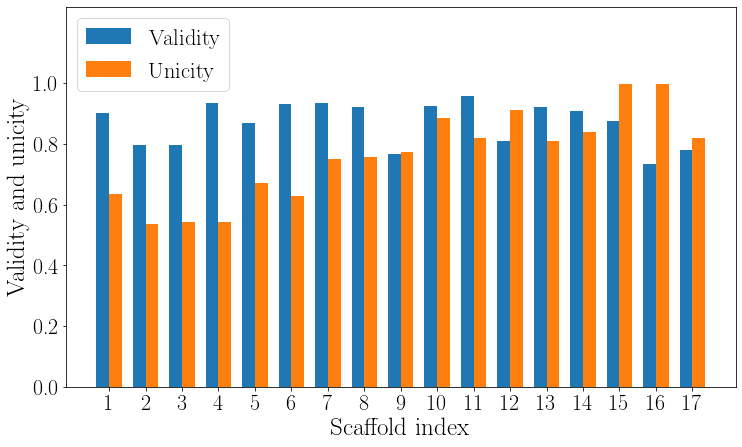

In [85]:
font = {'family' : 'normal',
        'size'   : 25}

labels = [str(i+1) for i in range(len(validity))]

counts = []
for scaff in scaffold:
    counts.append(scaff.count('*'))
indexes = np.argsort(np.array(counts))


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 7))
ax.set_ylim(0, 1.25)
rects1 = ax.bar(x - width/2, np.array(validity)[indexes], width, label='Validity')
rects2 = ax.bar(x + width/2, np.array(unicities)[indexes], width, label='Unicity')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Validity and unicity',fontsize=25)
ax.set_xlabel('Scaffold index',fontsize=25)
#ax.set_title('Validity and unicity proportion across 10000 molecules for each scaffold', fontsize=25)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=22)

y = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticks(y)
ax.set_yticklabels(y, fontsize=22)
ax.legend(prop={'size': 22.5}, loc=2)

plt.savefig('validity_unicity.pgf')

#plt.show()

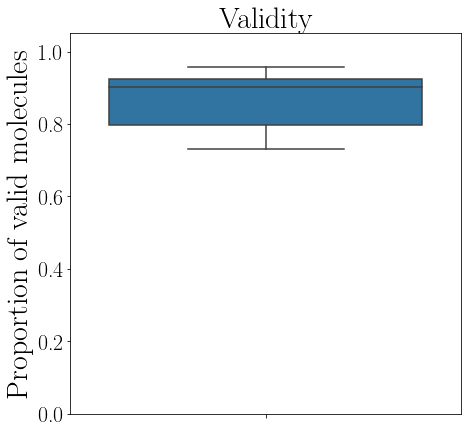

In [90]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

fig, ax = plt.subplots()
fig.set_size_inches(w=7, h=7)

ax.set_title('Validity', fontsize=30)
ax.set_ylabel("Proportion of valid molecules",fontsize=30)
ax = sns.boxplot(x=validity, orient='v')
ax.set_ylim(0, 1.05)

y = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticks(y)
ax.set_yticklabels(y, fontsize=22)

loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.savefig('validity.pgf')

# plt.show()

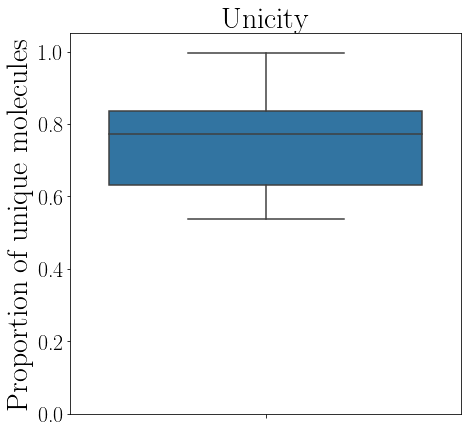

In [91]:


fig, ax = plt.subplots()
fig.set_size_inches(w=7, h=7)

ax.set_title('Unicity', fontsize=30)
ax.set_ylabel("Proportion of unique molecules",fontsize=30)
ax = sns.boxplot(x=unicities, orient='v')
ax.set_ylim(0, 1.05)

y = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticks(y)
ax.set_yticklabels(y, fontsize=22)

loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.savefig('unicity.pgf')
# plt.show()

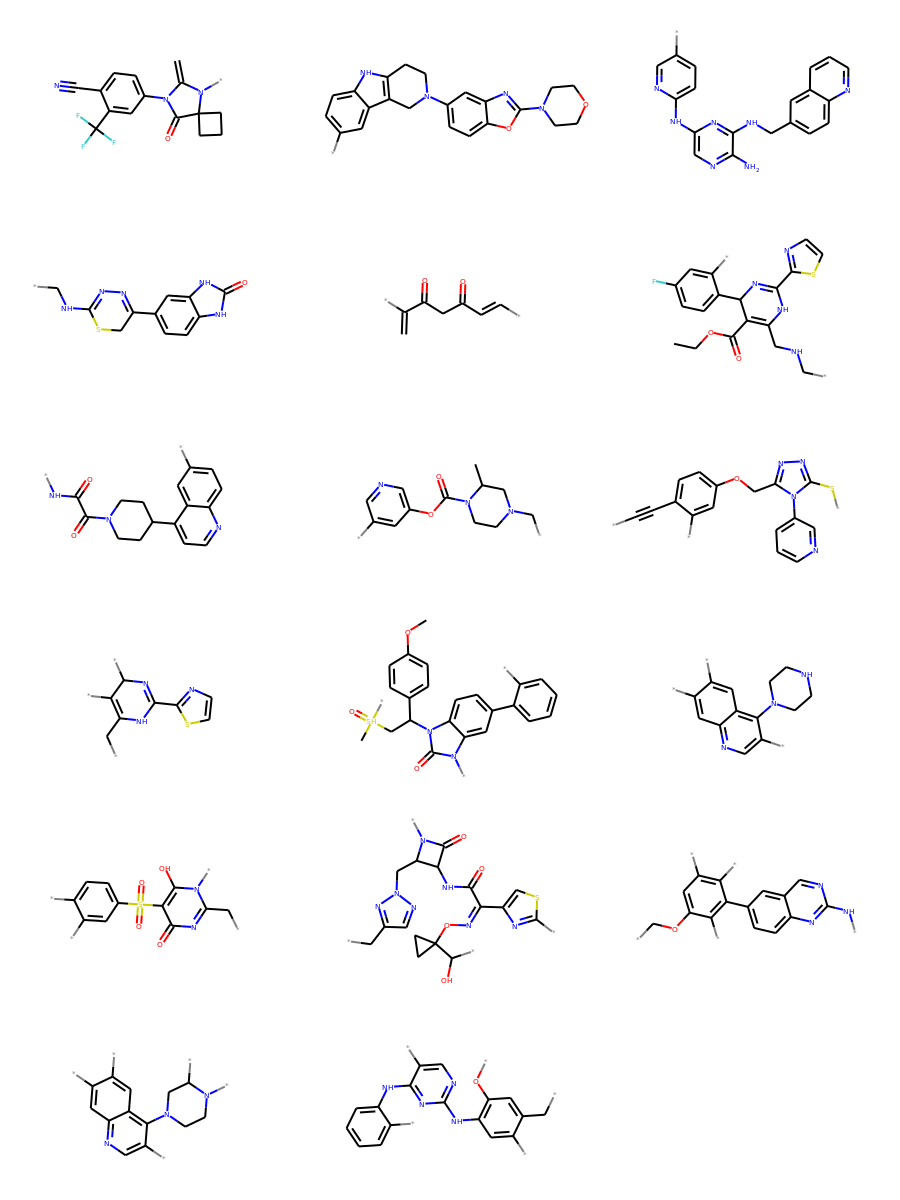

In [108]:
from rdkit.Chem import Draw
from rdkit import Chem

Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in np.array(["N(*)2C(=C)N(c3ccc(C#N)c(C(F)(F)F)c3)C(=O)C23CCC3",
            'C(*)N2CCN(C(=O)Oc3cncc(*)c3)C(C)C2',
            'c(*)1ccc(Nc2cnc(N)c(NCc3ccc4ncccc4c3)n2)nc1',
            'N(*)C(=O)C(=O)N2CCC(c3ccnc4ccc(*)cc34)CC2',
            'C(*)c1nc(=O)c(S(=O)(=O)c2ccc(*)c(*)c2)c(O)n1(*)',
            'C(*)c1cnn(CC2C(NC(=O)C(=NOC3(C(*)O)CC3)c3csc(*)n3)C(=O)N2(*))n1',
            'C(*)Oc1cc(*)c(*)c(c2ccc3nc(N(*))ncc3c2)c1(*)', #6
            'c(*)1cnc2cc(*)c(*)cc2c1N1CCN(*)C(*)C1',
            'c1(*)cnc2cc(*)c(*)cc2c1N1CCNCC1',#8
            'C(*)NC2=NN=C(c3ccc4[nH]c(=O)[nH]c4c3)CS2', #10
            'C(*)#Cc1ccc(OCc2nnc(S(*))n2-c2cccnc2)cc1(*)',
            'C(*)C1=C(*)C(*)N=C(c2nccs2)N1',#12
            'S(*)(C)(=O)CC(c1ccc(OC)cc1)n1c(=O)n(*)c2cc(-c3ccccc3(*))ccc21',
            'c(*)1ccc2[nH]c3c(c2c1)CN(c1ccc2oc(N4CCOCC4)nc2c1)CC3',#14
            'c(*)1cc(Nc2ncc(*)c(Nc3ccccc3(*))n2)c(O(*))cc1C(*)',
            'C=C(*)C(=O)CC(=O)C=C(*)', #16
            'C(*)N(CC2=C(C(=O)OCC)C(c3ccc(F)cc3(*))N=C(c3nccs3)N2)'])[indexes]], molsPerRow=3, subImgSize=(300, 200))

# Plotting distributions

In [45]:
# Getting molecules from SureChEMBL ("validation set" in the paper)
suppl = Chem.SDMolSupplier('data/SureChEMBL/200323_SureChemBL_dataset_636.sdf')
smiles = []
series = []
comparisons = []
for i, mol in enumerate(suppl):
    series.append(mol.GetProp('Series_Name'))
    smiles.append(Chem.MolToSmiles(mol))
    comparisons.append(mol)
    
logP_Chembl_original = []
MW_Chembl_original = []
qed_list_Chembl_original = []
SAS_Chembl_original = []
HBA_ChEMBL_original = []
HBD_ChEMBL_original = []
for mol in comparisons:    
    try:
        SAS_Chembl_original.append(calculateScore(mol))
        MW_Chembl_original.append(Descriptors.ExactMolWt(mol))
        logP_Chembl_original.append(Descriptors.MolLogP(mol))
        qed_list_Chembl_original.append(QED.qed(mol))
        HBA_ChEMBL_original.append(Lipinski.NumHAcceptors(mol))
        HBD_ChEMBL_original.append(Lipinski.NumHDonors(mol))
    except:
        pass

In [46]:
# Getting a subset from ChEMBL ("training set" in the paper)
suppl = Chem.SmilesMolSupplier('data/ChEMBL_filtered',delimiter='\t')
count = 0
comparisons_chembl = []
for mol in suppl:
    comparisons.append(mol)
    count += 1
    if count>10000:
        break

    
logP_Chembl = []
MW_Chembl = []
qed_list_Chembl = []
SAS_Chembl = []
HBA_ChEMBL = []
HBD_ChEMBL = []

for mol in comparisons:   
    try:
        SAS_Chembl.append(calculateScore(mol))
        MW_Chembl.append(Descriptors.ExactMolWt(mol))
        logP_Chembl.append(Descriptors.MolLogP(mol))
        qed_list_Chembl.append(QED.qed(mol))
        HBA_ChEMBL.append(Lipinski.NumHAcceptors(mol))
        HBD_ChEMBL.append(Lipinski.NumHDonors(mol))
    except:
        pass

RDKit WARNING: [17:20:06] WARNING: no name column found on line 1
RDKit WARNING: [17:20:06] WARNING: no name column found on line 2
RDKit WARNING: [17:20:06] WARNING: no name column found on line 3
RDKit WARNING: [17:20:06] WARNING: no name column found on line 4
RDKit WARNING: [17:20:06] WARNING: no name column found on line 5
RDKit WARNING: [17:20:06] WARNING: no name column found on line 6
RDKit WARNING: [17:20:06] WARNING: no name column found on line 7
RDKit WARNING: [17:20:06] WARNING: no name column found on line 8
RDKit WARNING: [17:20:06] WARNING: no name column found on line 9
RDKit WARNING: [17:20:06] WARNING: no name column found on line 10
RDKit WARNING: [17:20:06] WARNING: no name column found on line 11
RDKit WARNING: [17:20:06] WARNING: no name column found on line 12
RDKit WARNING: [17:20:06] WARNING: no name column found on line 13
RDKit WARNING: [17:20:06] WARNING: no name column found on line 14
RDKit WARNING: [17:20:06] WARNING: no name column found on line 15
RDKi

RDKit WARNING: [17:20:07] WARNING: no name column found on line 2052
RDKit WARNING: [17:20:07] WARNING: no name column found on line 2053
RDKit WARNING: [17:20:07] WARNING: no name column found on line 2054
RDKit WARNING: [17:20:07] WARNING: no name column found on line 2055
RDKit WARNING: [17:20:07] WARNING: no name column found on line 2056
RDKit WARNING: [17:20:07] WARNING: no name column found on line 2057
RDKit WARNING: [17:20:07] WARNING: no name column found on line 2058
RDKit WARNING: [17:20:07] WARNING: no name column found on line 2059
RDKit WARNING: [17:20:07] WARNING: no name column found on line 2060
RDKit WARNING: [17:20:07] WARNING: no name column found on line 2061
RDKit WARNING: [17:20:07] WARNING: no name column found on line 2062
RDKit WARNING: [17:20:07] WARNING: no name column found on line 2063
RDKit WARNING: [17:20:07] WARNING: no name column found on line 2064
RDKit WARNING: [17:20:07] WARNING: no name column found on line 2065
RDKit WARNING: [17:20:07] WARNING:

RDKit WARNING: [17:20:07] WARNING: no name column found on line 3051
RDKit WARNING: [17:20:07] WARNING: no name column found on line 3052
RDKit WARNING: [17:20:07] WARNING: no name column found on line 3053
RDKit WARNING: [17:20:07] WARNING: no name column found on line 3054
RDKit WARNING: [17:20:07] WARNING: no name column found on line 3055
RDKit WARNING: [17:20:07] WARNING: no name column found on line 3056
RDKit WARNING: [17:20:07] WARNING: no name column found on line 3057
RDKit WARNING: [17:20:07] WARNING: no name column found on line 3058
RDKit WARNING: [17:20:07] WARNING: no name column found on line 3059
RDKit WARNING: [17:20:07] WARNING: no name column found on line 3060
RDKit WARNING: [17:20:07] WARNING: no name column found on line 3061
RDKit WARNING: [17:20:07] WARNING: no name column found on line 3062
RDKit WARNING: [17:20:07] WARNING: no name column found on line 3063
RDKit WARNING: [17:20:07] WARNING: no name column found on line 3064
RDKit WARNING: [17:20:07] WARNING:

RDKit WARNING: [17:20:07] WARNING: no name column found on line 3948
RDKit WARNING: [17:20:07] WARNING: no name column found on line 3949
RDKit WARNING: [17:20:07] WARNING: no name column found on line 3950
RDKit WARNING: [17:20:07] WARNING: no name column found on line 3951
RDKit WARNING: [17:20:07] WARNING: no name column found on line 3952
RDKit WARNING: [17:20:07] WARNING: no name column found on line 3953
RDKit WARNING: [17:20:07] WARNING: no name column found on line 3954
RDKit WARNING: [17:20:07] WARNING: no name column found on line 3955
RDKit WARNING: [17:20:07] WARNING: no name column found on line 3956
RDKit WARNING: [17:20:07] WARNING: no name column found on line 3957
RDKit WARNING: [17:20:07] WARNING: no name column found on line 3958
RDKit WARNING: [17:20:07] WARNING: no name column found on line 3959
RDKit WARNING: [17:20:07] WARNING: no name column found on line 3960
RDKit WARNING: [17:20:07] WARNING: no name column found on line 3961
RDKit WARNING: [17:20:07] WARNING:

RDKit WARNING: [17:20:08] WARNING: no name column found on line 5049
RDKit WARNING: [17:20:08] WARNING: no name column found on line 5050
RDKit WARNING: [17:20:08] WARNING: no name column found on line 5051
RDKit WARNING: [17:20:08] WARNING: no name column found on line 5052
RDKit WARNING: [17:20:08] WARNING: no name column found on line 5053
RDKit WARNING: [17:20:08] WARNING: no name column found on line 5054
RDKit WARNING: [17:20:08] WARNING: no name column found on line 5055
RDKit WARNING: [17:20:08] WARNING: no name column found on line 5056
RDKit WARNING: [17:20:08] WARNING: no name column found on line 5057
RDKit WARNING: [17:20:08] WARNING: no name column found on line 5058
RDKit WARNING: [17:20:08] WARNING: no name column found on line 5059
RDKit WARNING: [17:20:08] WARNING: no name column found on line 5060
RDKit WARNING: [17:20:08] WARNING: no name column found on line 5061
RDKit WARNING: [17:20:08] WARNING: no name column found on line 5062
RDKit WARNING: [17:20:08] WARNING:

RDKit WARNING: [17:20:08] WARNING: no name column found on line 6048
RDKit WARNING: [17:20:08] WARNING: no name column found on line 6049
RDKit WARNING: [17:20:08] WARNING: no name column found on line 6050
RDKit WARNING: [17:20:08] WARNING: no name column found on line 6051
RDKit WARNING: [17:20:08] WARNING: no name column found on line 6052
RDKit WARNING: [17:20:08] WARNING: no name column found on line 6053
RDKit WARNING: [17:20:08] WARNING: no name column found on line 6054
RDKit WARNING: [17:20:08] WARNING: no name column found on line 6055
RDKit WARNING: [17:20:08] WARNING: no name column found on line 6056
RDKit WARNING: [17:20:08] WARNING: no name column found on line 6057
RDKit WARNING: [17:20:08] WARNING: no name column found on line 6058
RDKit WARNING: [17:20:08] WARNING: no name column found on line 6059
RDKit WARNING: [17:20:08] WARNING: no name column found on line 6060
RDKit WARNING: [17:20:08] WARNING: no name column found on line 6061
RDKit WARNING: [17:20:08] WARNING:

RDKit WARNING: [17:20:09] WARNING: no name column found on line 7047
RDKit WARNING: [17:20:09] WARNING: no name column found on line 7048
RDKit WARNING: [17:20:09] WARNING: no name column found on line 7049
RDKit WARNING: [17:20:09] WARNING: no name column found on line 7050
RDKit WARNING: [17:20:09] WARNING: no name column found on line 7051
RDKit WARNING: [17:20:09] WARNING: no name column found on line 7052
RDKit WARNING: [17:20:09] WARNING: no name column found on line 7053
RDKit WARNING: [17:20:09] WARNING: no name column found on line 7054
RDKit WARNING: [17:20:09] WARNING: no name column found on line 7055
RDKit WARNING: [17:20:09] WARNING: no name column found on line 7056
RDKit WARNING: [17:20:09] WARNING: no name column found on line 7057
RDKit WARNING: [17:20:09] WARNING: no name column found on line 7058
RDKit WARNING: [17:20:09] WARNING: no name column found on line 7059
RDKit WARNING: [17:20:09] WARNING: no name column found on line 7060
RDKit WARNING: [17:20:09] WARNING:

RDKit WARNING: [17:20:09] WARNING: no name column found on line 8046
RDKit WARNING: [17:20:09] WARNING: no name column found on line 8047
RDKit WARNING: [17:20:09] WARNING: no name column found on line 8048
RDKit WARNING: [17:20:09] WARNING: no name column found on line 8049
RDKit WARNING: [17:20:09] WARNING: no name column found on line 8050
RDKit WARNING: [17:20:09] WARNING: no name column found on line 8051
RDKit WARNING: [17:20:09] WARNING: no name column found on line 8052
RDKit WARNING: [17:20:09] WARNING: no name column found on line 8053
RDKit WARNING: [17:20:09] WARNING: no name column found on line 8054
RDKit WARNING: [17:20:09] WARNING: no name column found on line 8055
RDKit WARNING: [17:20:09] WARNING: no name column found on line 8056
RDKit WARNING: [17:20:09] WARNING: no name column found on line 8057
RDKit WARNING: [17:20:09] WARNING: no name column found on line 8058
RDKit WARNING: [17:20:09] WARNING: no name column found on line 8059
RDKit WARNING: [17:20:09] WARNING:

RDKit WARNING: [17:20:09] WARNING: no name column found on line 9045
RDKit WARNING: [17:20:09] WARNING: no name column found on line 9046
RDKit WARNING: [17:20:09] WARNING: no name column found on line 9047
RDKit WARNING: [17:20:09] WARNING: no name column found on line 9048
RDKit WARNING: [17:20:09] WARNING: no name column found on line 9049
RDKit WARNING: [17:20:09] WARNING: no name column found on line 9050
RDKit WARNING: [17:20:09] WARNING: no name column found on line 9051
RDKit WARNING: [17:20:09] WARNING: no name column found on line 9052
RDKit WARNING: [17:20:09] WARNING: no name column found on line 9053
RDKit WARNING: [17:20:09] WARNING: no name column found on line 9054
RDKit WARNING: [17:20:09] WARNING: no name column found on line 9055
RDKit WARNING: [17:20:09] WARNING: no name column found on line 9056
RDKit WARNING: [17:20:09] WARNING: no name column found on line 9057
RDKit WARNING: [17:20:09] WARNING: no name column found on line 9058
RDKit WARNING: [17:20:09] WARNING:

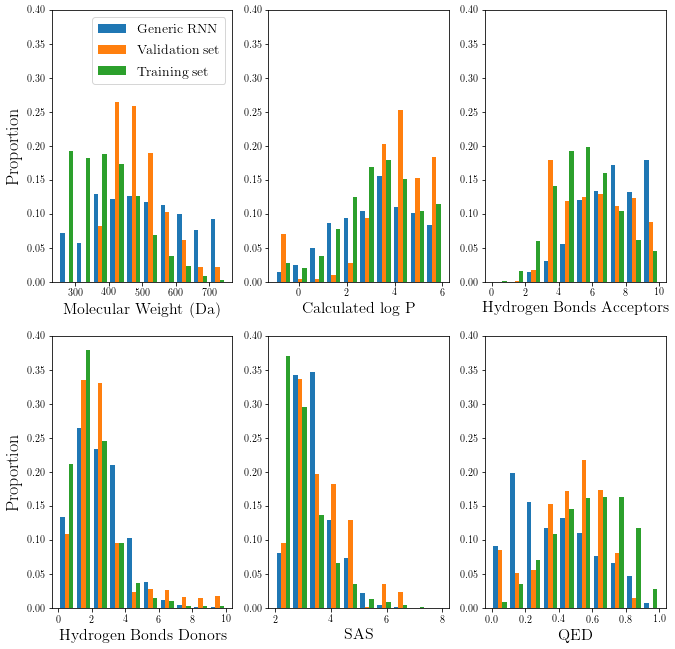

In [105]:
plt.figure(figsize=(11, 11))


# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

MW_binned = np.fmin(np.fmax(MW, 250 * np.ones_like(MW)), 750 * np.ones_like(MW))
MW_Chembl_original_binned = np.fmin(np.fmax(MW_Chembl_original, 250 * np.ones_like(MW_Chembl_original)), 750 * np.ones_like(MW_Chembl_original))
MW_Chembl_binned = np.fmin(np.fmax(MW_Chembl, 250 * np.ones_like(MW_Chembl)), 750 * np.ones_like(MW_Chembl))

plt.subplot(231)
plt.hist([MW_binned, MW_Chembl_original_binned, MW_Chembl_binned], range=(250, 750), weights=[np.ones(len(MW)) / len(MW),
                                                       np.ones(len(MW_Chembl_original)) / len(MW_Chembl_original),
                                                       np.ones(len(MW_Chembl)) / len(MW_Chembl),], label=['Generic RNN', 'Validation set', 'Training set'])
plt.ylim(0, 0.4)
plt.legend(loc=1, prop={'size': 14})


plt.ylabel('Proportion', fontsize=18)
plt.xlabel('Molecular Weight (Da)', fontsize=16)
logP_binned = np.fmin(np.fmax(logP, -1 * np.ones_like(logP)), 6 * np.ones_like(logP))
logP_Chembl_binned = np.fmin(np.fmax(logP_Chembl, -1 * np.ones_like(logP_Chembl)), 6 * np.ones_like(logP_Chembl))
logP_Chembl_original_binned = np.fmin(np.fmax(logP_Chembl_original, -1 * np.ones_like(logP_Chembl_original)), 6 * np.ones_like(logP_Chembl_original))

plt.subplot(232)
plt.hist([logP, logP_Chembl_original_binned, logP_Chembl_binned], range=[-1, 6], weights=[np.ones(len(logP)) / len(logP),
                                                       np.ones(len(logP_Chembl_original_binned)) / len(logP_Chembl_original_binned),
                                                       np.ones(len(logP_Chembl_binned)) / len(logP_Chembl_binned),], label=['Generated molecules', 'SureChEMBL molecules', 'ChEMBL molecules'])
plt.ylim(0, 0.4)
plt.xlabel('Calculated log P', fontsize=16)


plt.subplot(233)
plt.hist([HBA, HBA_ChEMBL_original, HBA_ChEMBL], weights=[np.ones(len(HBA)) / len(HBA),
                                                       np.ones(len(HBA_ChEMBL_original)) / len(HBA_ChEMBL_original),
                                                       np.ones(len(HBA_ChEMBL)) / len(HBA_ChEMBL),], range= (0,10), label=['Generated molecules', 'SureChEMBL molecules', 'ChEMBL molecules'])
plt.ylim(0, 0.4)
plt.xlabel('Hydrogen Bonds Acceptors', fontsize=16)

plt.subplot(234)
plt.hist([HBD, HBD_ChEMBL_original, HBD_ChEMBL], weights=[np.ones(len(HBD)) / len(HBD),
                                                       np.ones(len(HBD_ChEMBL_original)) / len(HBD_ChEMBL_original),
                                                       np.ones(len(HBD_ChEMBL)) / len(HBD_ChEMBL),], range= (0,10), label=['Generated molecules', 'SureChEMBL molecules', 'ChEMBL molecules'])
plt.ylim(0, 0.4)
plt.ylabel('Proportion', fontsize=18)
plt.xlabel('Hydrogen Bonds Donors', fontsize=16)

plt.subplot(235)
plt.hist([SAS, SAS_Chembl_original, SAS_Chembl], weights=[np.ones(len(SAS)) / len(SAS),
                                                       np.ones(len(SAS_Chembl_original)) / len(SAS_Chembl_original),
                                                       np.ones(len(SAS_Chembl)) / len(SAS_Chembl),], range= (2,8), label=['Generated molecules', 'SureChEMBL molecules', 'ChEMBL molecules'])
plt.ylim(0, 0.4)
plt.xlabel('SAS', fontsize=16)

plt.subplot(236)
plt.hist([QEDs, qed_list_Chembl_original, qed_list_Chembl], weights=[np.ones(len(QEDs)) / len(QEDs),
                                                       np.ones(len(qed_list_Chembl_original)) / len(qed_list_Chembl_original),
                                                       np.ones(len(qed_list_Chembl)) / len(qed_list_Chembl),], range= (0,1), label=['Generic RNN', 'Validation set', 'Training set'])
plt.ylim(0, 0.4)
plt.xlabel('QED', fontsize=16)
plt.savefig('distributions.pgf')
